In [2]:
import pandas as pd 
import numpy as np 

df = pd.read_csv('winequality-red.csv')

df.head()

,"fixed acidity;""volatile acidity"";""citric acid"";""residual sugar"";""chlorides"";""free sulfur dioxide"";""total sulfur dioxide"";""density"";""pH"";""sulphates"";""alcohol"";""quality"""
0,7.4;0.7;0;1.9;0.076;11;34;0.9978;3.51;0.56;9.4;5
1,7.8;0.88;0;2.6;0.098;25;67;0.9968;3.2;0.68;9.8;5
2,7.8;0.76;0.04;2.3;0.092;15;54;0.997;3.26;0.65;...
3,11.2;0.28;0.56;1.9;0.075;17;60;0.998;3.16;0.58...
4,7.4;0.7;0;1.9;0.076;11;34;0.9978;3.51;0.56;9.4;5


The dataset has 1599 rows, but all the columns are combined together into one. Let's clean the data by splitting the columns, and then split the dataframe into an output and input dataframe. 

In [3]:
from sklearn.model_selection import train_test_split
from sklearn import decomposition
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt # Plotting 
import matplotlib.ticker as mtick

combined_column_name = df.columns.format()[0] # Extract string of mashed up column names
columns_cleaned = combined_column_name.split(sep = ';') # Split variables into list
columns_cleaned = [i.strip('""') for i in columns_cleaned] # Remove unnecessary quotation marks

df[columns_cleaned] = df[combined_column_name].str.split(';', expand = True) # Create split columns
df = df.drop(combined_column_name, axis = 1) # Remove the original column that is now redundant

X = df.drop('quality', axis = 1) # Extract features
y = df['quality'] # Extract output (we won't need this for PCA)


Next, we scale the data and then apply PCA.

In [4]:


# https://www.geeksforgeeks.org/implementing-pca-in-python-with-scikit-learn/

X = scale(X)
pca = decomposition.PCA()
pca.fit(X)



PCA()

Let's now analyze the results. First, we look at the scores, which express each of the data observations in terms of the principal component basis. Then we plot the scores with respect to the first 3 principal components.

In [5]:
scores = pca.transform(X)
scores_df = pd.DataFrame(scores, columns = [f'PC{i}' for i in range(1, 12)])
scores_df_combined = pd.concat([scores_df, y], axis = 1)
scores_df_combined['quality'] = scores_df_combined['quality'].astype(float)


In [6]:
import plotly.express as px

fig = px.scatter_3d(scores_df_combined, x='PC1', y='PC2', z='PC3',
              color='quality', opacity = 0.2)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()


The score plot doesn't show discrete clusters so much as a smooth gradient toward better wines. It seems that having a negative 2nd principal component score and a positive 3rd is somewhat predictive of a good quality. We will later more formally investigate this.

Next, we display the loadings, which explicity specify the linear combinations of each variable that determines a principal component.

In [7]:

loadings = pca.components_.T
df_loadings = pd.DataFrame(loadings, columns = [f'PC{i}' for i in range(1, 12)], index = columns_cleaned[0:11])
df_loadings.round(2)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11
fixed acidity,0.49,-0.11,-0.12,-0.23,-0.08,0.10,-0.35,-0.18,-0.19,-0.25,0.64
volatile acidity,-0.24,0.27,-0.45,0.08,0.22,0.41,-0.53,-0.08,0.13,0.37,0.00
citric acid,0.46,-0.15,0.24,-0.08,-0.06,0.07,0.11,-0.38,0.38,0.62,-0.07
residual sugar,0.15,0.27,0.10,-0.37,0.73,0.05,0.29,0.30,-0.01,0.09,0.18
chlorides,0.21,0.15,-0.09,0.67,0.25,0.30,0.37,-0.36,-0.11,-0.22,0.05
free sulfur dioxide,-0.04,0.51,0.43,-0.04,-0.16,-0.01,-0.12,-0.20,-0.64,0.25,-0.05
total sulfur dioxide,0.02,0.57,0.32,-0.03,-0.22,0.14,-0.09,0.02,0.59,-0.37,0.07
density,0.40,0.23,-0.34,-0.17,0.16,-0.39,-0.17,-0.24,-0.02,-0.24,-0.57
pH,-0.44,0.01,0.06,-0.00,0.27,-0.52,-0.03,-0.56,0.17,-0.01,0.34
sulphates,0.24,-0.04,0.28,0.55,0.23,-0.38,-0.45,0.37,0.06,0.11,0.07


In [8]:
loadings_label = df_loadings.index
# loadings_label = df_loadings.index.str.strip(' (cm)')

fig = px.scatter(df_loadings, x='PC1', y='PC2',
                    text = loadings_label)

fig.show()

The loadings plot seems to show measures of acidity along the first principal component (pH, fixed acidity, citric acidity). The second principal component measure alcohol content and sulfur dioxide.

Now, let's transition to a supervised learning approach and aim to predict wine quality. We will use many different regression tools, including linear regression, k-nearest neighbors, random forests. For the latter two techniques, we will need to tune some hyperparameters.

In [9]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

df = pd.read_csv('winequality-red.csv')

combined_column_name = df.columns.format()[0] # Extract string of mashed up column names
columns_cleaned = combined_column_name.split(sep = ';') # Split variables into list
columns_cleaned = [i.strip('""') for i in columns_cleaned] # Remove unnecessary quotation marks

df[columns_cleaned] = df[combined_column_name].str.split(';', expand = True) # Create split columns
df = df.drop(combined_column_name, axis = 1) # Remove the original column that is now redundant

X = df.drop('quality', axis = 1) # Extract features
y = df['quality'] # Extract output (we won't need this for PCA)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Let's start with some linear regression.

In [10]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
lin_model_pred = lin_model.predict(X_test)
mse = mean_squared_error(y_test, lin_model_pred)
mse

0.44208171356433956

In [11]:
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV

knn_model = neighbors.KNeighborsRegressor(n_neighbors = 5) # default is k = 5
knn_model.fit(X_train, y_train)
knn_model_pred = knn_model.predict(X_test)
'''
knn_pred = knn_model.predict(X_test)

mse_knn = mean_squared_error(y_test, knn_pred)
print('MSE of KNN on test data:', mse_knn)

grid_params = {
    'n_neighbors' : [1, 3],
    'weights' : ['uniform', 'distance'],
    'metric' : ['euclidean']
}

grid_search = GridSearchCV(
    KNeighborsRegressor(),
    grid_params,
    verbose = 1,
    cv = 5,
    n_jobs = -1
)

grid_search_results = grid_search.fit(X_train, y_train)

print('best_score:', grid_search_results.best_score)
print('best_estimator:', grid_search_results.best_estimator)
print('best_params:', grid_search_results.best_params)
'''

TypeError: unsupported operand type(s) for /: 'str' and 'int'

In [39]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
mse_rf = mean_squared_error(y_test, rf_pred)

print('MSE on test data: ', mse_rf)



MSE on test data:  0.37609312500000003
Fitting 5 folds for each of 9 candidates, totalling 45 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   13.3s finished
best_score: 0.5002945403275593
best_estimator: RandomForestRegressor(max_features=5, n_estimators=500)
best_params: {'max_features': 5, 'n_estimators': 500}


In [41]:
grid_params = {
    'n_estimators' : [100, 250, 500],
    'max_features' : [2, 5, 10]
}

grid_search = GridSearchCV(
    RandomForestRegressor(),
    grid_params,
    verbose = 1,
    cv = 5,
    n_jobs = -1
)

grid_search_results = grid_search.fit(X_train, y_train)
print('best_score:', grid_search_results.best_score_)
print('best_estimator:', grid_search_results.best_estimator_)
print('best_params:', grid_search_results.best_params_)

best_rf_predict = grid_search_results.predict(X_test)
mse_rf_best = mean_squared_error(y_test, best_rf_predict)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   12.8s finished
best_score: 0.501041117443814
best_estimator: RandomForestRegressor(max_features=5, n_estimators=500)
best_params: {'max_features': 5, 'n_estimators': 500}


In [42]:
mse_rf_best

0.37494297500000007

The linear regression model attained a mean squared error of 0.48, while random forests took it to 0.37 (tuning did not make a large difference).

(array([681.,   0., 638.,   0., 199.,   0.,  53.,   0.,  18.,  10.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

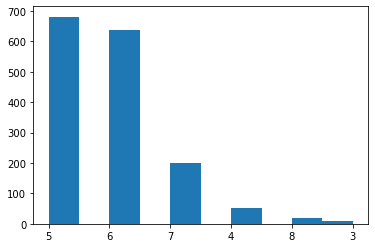

In [12]:

# We can set the number of bins with the `bins` kwarg
plt.hist(df['quality'])

Unfortunately, a histogram of qualities shows that the data is very imbalanced, on the extremes of 3, 4, and 8.